In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import seaborn as sns
import fbprophet
from scipy import stats

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importing data
population = pd.read_csv('population.csv', skiprows=4, index_col=0, na_values = ' ')
energy = pd.read_csv('energy.csv', skiprows=4, index_col=0, na_values=' ')
gdp = pd.read_csv('gdp.csv', skiprows=3, index_col=0, na_values = ' ')

#Cleaning up unneeded columns
population = population.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
energy = energy.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
gdp = gdp.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

gdp = gdp.drop(['Unnamed: 64'], axis=1)

gdp = gdp.drop(gdp.loc[:, '1960':'1970'].columns, axis =1)
gdp = gdp.drop(gdp.loc[:, '2015':'2019'].columns, axis =1)

population = population.drop(population.loc[:, '1960':'1970'].columns, axis =1)
population = population.drop(population.loc[:, '2015':'2019'].columns, axis =1)

energy = energy.drop(energy.loc[:, '1960':'1970'].columns, axis =1)
energy = energy.drop(energy.loc[:, '2015':'2019'].columns, axis =1)

Extracting US and China data into two new DataFrame: US, China

In [3]:
US = population.loc['United States']
US = pd.DataFrame(US)
US['GDP'] = gdp.loc['United States']/population.loc['United States']
US['Energy'] = energy.loc['United States']
US = US.rename(columns={'United States':'Population'})

In [4]:
US.index = US.index.astype(int)

In [5]:
US.head()

,Population,GDP,Energy
1971,207661000.0,5609.382600,7644.524802
1972,209896000.0,6094.017990,7940.997832
1973,211909000.0,6726.358956,8163.603792
1974,213854000.0,7225.691360,7909.586480
1975,215973000.0,7801.456664,7656.263579


In [6]:
China = population.loc['China']
China = pd.DataFrame(China)
China['GDP'] = gdp.loc['China']/population.loc['China']
China['Energy'] = energy.loc['China']
China = China.rename(columns={'China':'Population'})

In [7]:
China.index = China.index.astype(int)

Text(0.5, 1.0, 'Total Energy Cunsumption vs Population for U.S. and China')

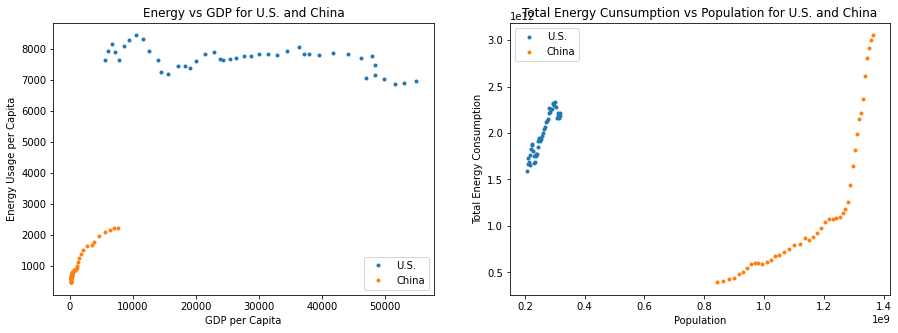

In [8]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(US.GDP, US.Energy, China.GDP, China.Energy, linestyle='none', marker='.')
plt.legend(['U.S.', 'China'])
plt.xlabel('GDP per Capita')
plt.ylabel('Energy Usage per Capita')
plt.title('Energy vs GDP for U.S. and China')

plt.subplot(1,2,2)
plt.plot(US.Population, US.Energy*US.Population, China.Population, China.Energy*China.Population, linestyle='none', marker='.')
plt.legend(['U.S.', 'China'])
plt.xlabel('Population')
plt.ylabel('Total Energy Consumption')
plt.title('Total Energy Cunsumption vs Population for U.S. and China')

Prepare new DataFrame to be used with Prophet. delta_df has its 'y' column contain the difference in Energy Consumption between US and China (per Capita values)

In [9]:
delta_df= pd.DataFrame()
delta_df['ds'] = US.index
delta_df['y'] = US.Energy.values - China.Energy.values
delta_df.ds = delta_df.ds.astype(str)

In [10]:
delta_df.head()

,ds,y
0,1971,7179.591645
1,1972,7463.829124
2,1973,7679.886417
3,1974,7423.418494
4,1975,7128.775242


In [11]:
delta_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
delta_prophet.fit(delta_df)
delta_forecast = delta_prophet.make_future_dataframe(periods=25, freq='Y')
delta_forecast = delta_prophet.predict(delta_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


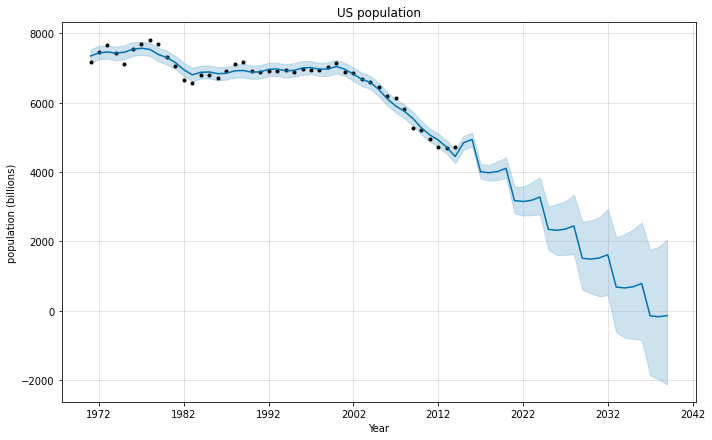

In [12]:
delta_prophet.plot(delta_forecast, xlabel = 'Year', ylabel = 'population (billions)')
plt.title('US population');

Listing the years when the difference starts to go below Zero. We will go one year above that 2035 when China Energy Consumption per Capita matches that of US's level. 

In [13]:
delta_forecast.loc[(delta_forecast.yhat<=0)].ds

66   2036-12-31
67   2037-12-31
68   2038-12-31
Name: ds, dtype: datetime64[ns]

## Forecasting China population by 2035

In [14]:
cn_pop = pd.DataFrame()

In [15]:
cn_pop['ds'] = China.index

In [16]:
cn_pop['y'] = China.Population.values

In [17]:
cn_pop.ds = cn_pop.ds.astype(str)

In [18]:
cn_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cn_prophet.fit(cn_pop)
cn_forecast = cn_prophet.make_future_dataframe(periods=25, freq='Y')
cn_forecast = cn_prophet.predict(cn_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


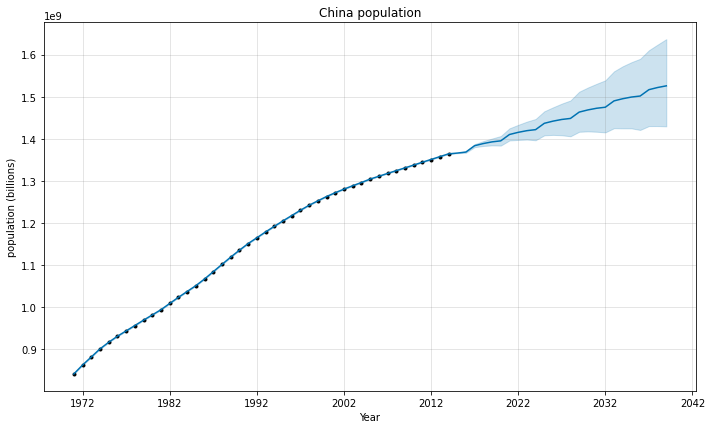

In [19]:
cn_prophet.plot(cn_forecast, xlabel = 'Year', ylabel = 'population (billions)')
plt.title('China population');

In [20]:
cn_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1971-01-01,4.562841e+07,8.408732e+08,8.413569e+08,4.562841e+07,4.562841e+07,7.954837e+08,7.954837e+08,7.954837e+08,7.954837e+08,7.954837e+08,7.954837e+08,0.0,0.0,0.0,8.411121e+08
1,1972-01-01,6.687601e+07,8.620403e+08,8.624979e+08,6.687601e+07,6.687601e+07,7.953986e+08,7.953986e+08,7.953986e+08,7.953986e+08,7.953986e+08,7.953986e+08,0.0,0.0,0.0,8.622746e+08
2,1973-01-01,8.608674e+07,8.811790e+08,8.816687e+08,8.608674e+07,8.608674e+07,7.953491e+08,7.953491e+08,7.953491e+08,7.953491e+08,7.953491e+08,7.953491e+08,0.0,0.0,0.0,8.814359e+08
3,1974-01-01,1.052450e+08,9.003639e+08,9.008322e+08,1.052450e+08,1.052450e+08,7.953574e+08,7.953574e+08,7.953574e+08,7.953574e+08,7.953574e+08,7.953574e+08,0.0,0.0,0.0,9.006024e+08
4,1975-01-01,1.209113e+08,9.161578e+08,9.166340e+08,1.209113e+08,1.209113e+08,7.954837e+08,7.954837e+08,7.954837e+08,7.954837e+08,7.954837e+08,7.954837e+08,0.0,0.0,0.0,9.163950e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2034-12-31,7.086596e+08,1.424842e+09,1.582125e+09,6.343672e+08,7.914071e+08,7.905880e+08,7.905880e+08,7.905880e+08,7.905880e+08,7.905880e+08,7.905880e+08,0.0,0.0,0.0,1.499248e+09
65,2035-12-31,7.153138e+08,1.421062e+09,1.590179e+09,6.347220e+08,8.040181e+08,7.863777e+08,7.863777e+08,7.863777e+08,7.863777e+08,7.863777e+08,7.863777e+08,0.0,0.0,0.0,1.501692e+09
66,2036-12-31,7.219863e+08,1.430254e+09,1.610440e+09,6.355154e+08,8.157125e+08,7.947729e+08,7.947729e+08,7.947729e+08,7.947729e+08,7.947729e+08,7.947729e+08,0.0,0.0,0.0,1.516759e+09
67,2037-12-31,7.286405e+08,1.430311e+09,1.623870e+09,6.369663e+08,8.306282e+08,7.932783e+08,7.932783e+08,7.932783e+08,7.932783e+08,7.932783e+08,7.932783e+08,0.0,0.0,0.0,1.521919e+09


## Forecasting China Energy Consumption by 2035

In [22]:
temp_cn_eng = pd.DataFrame()

In [23]:
temp_cn_eng['ds'] = China.index

In [24]:
temp_cn_eng['y'] = China.Energy.values

In [25]:
temp_cn_eng.ds = temp_cn_eng.ds.astype(str)

In [26]:
cn_eng_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cn_eng_prophet.fit(temp_cn_eng)
cn_eng_forecast = cn_eng_prophet.make_future_dataframe(periods=25, freq='Y')
cn_eng_forecast = cn_eng_prophet.predict(cn_eng_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
print('China Total Energy Consumption in 2035 compared to 2014: ', 
      (cn_forecast.loc[65].yhat*cn_eng_forecast.loc[65].yhat)/(China.loc[2014].Energy*China.loc[2014].Population))

China Total Energy Consumption in 2035 compared to 2014:  2.272784300271042


In [28]:
print('China Total Energy Consumption 2035 compared to the whole world consumption in 2014: ', 
      (cn_forecast.loc[65].yhat*cn_eng_forecast.loc[65].yhat)/(energy.loc['World']['2014']*population.loc['World']['2014']))

China Total Energy Consumption 2035 compared to the whole world consumption in 2014:  0.49720097969062305
